In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import math
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [3]:
import os
import sys
sys.path.append('../ift6758/visualizations/')

from question_3_plots import *

In [4]:
experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name="logistic-regression-basicmodel-q3",
    workspace="kleitoun"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/logistic-regression-basicmodel-q3/11e0d31aa4a64d98a95fa7f8473d39cb



In [5]:
df = pd.read_csv('mid_df.csv')

# Accuracy of Baseline Model

Accuracy score of Training a Logistic Regression classifier with distance feature is: 0.9064830530267963
Total goals predicted by the classifier = 0


{'web': 'https://www.comet.ml/api/asset/download?assetId=c6585dbe093e49db94292417affe3746&experimentKey=11e0d31aa4a64d98a95fa7f8473d39cb',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=c6585dbe093e49db94292417affe3746&experimentKey=11e0d31aa4a64d98a95fa7f8473d39cb',
 'assetId': 'c6585dbe093e49db94292417affe3746'}

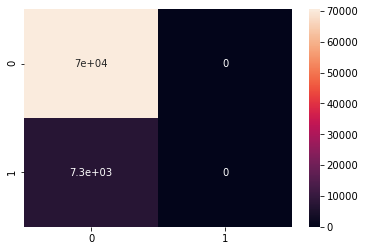

In [6]:
df_log = df.copy()
cnt = 0
X = df_log['distance_from_net']
y = df_log['goal_ind']

X_trainlog, X_validlog, y_trainlog, y_validlog = train_test_split(X,y,test_size=0.25,random_state=10, shuffle = True,)
clf = LogisticRegression()
clf.fit(X_trainlog.values.reshape(-1,1), y_trainlog)
y_predlog = clf.predict(X_validlog.values.reshape(-1,1))
predicted_prob = clf.predict_proba(X_validlog.values.reshape(-1,1))
score = clf.score(X_validlog.values.reshape(-1,1), y_validlog)
print("Accuracy score of Training a Logistic Regression classifier with distance feature is: {}".format(score))
[cnt+1 if y_predlog[ele]==1 else cnt+0 for ele in range(len(X_validlog))]
print("Total goals predicted by the classifier = {}".format(cnt))
cm = confusion_matrix(y_validlog, y_predlog)
import seaborn as sns
sns.heatmap(cm, annot=True)    
experiment.log_metric("accuracy", accuracy_score(y_validlog, y_predlog))
experiment.log_metric("f1_score", f1_score(y_validlog, y_predlog))
experiment.log_confusion_matrix(y_validlog, y_predlog)

# Potential Issue : Class Imbalance
# Class 0 (no-goal) vs. Class 1 (goal) of the whole training set before split

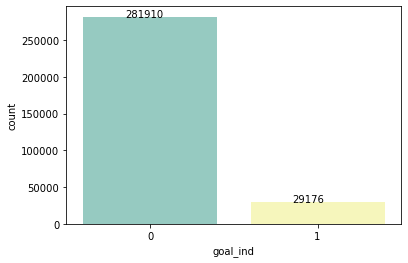

In [7]:
ax = sns.countplot(x='goal_ind', data = df_log, palette = 'Set3')
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

# Logistic Regression

In [8]:
def call_log_reg(X_train2,y_train,X_valid2,y_valid):
    global y_pred
    global predicted_prob
    global score

    clf = LogisticRegression()
    clf.fit(X_train2, y_train)
    y_pred = clf.predict(X_valid2)
    predicted_prob = clf.predict_proba(X_valid2)
    score = clf.score(X_valid2, y_valid)

In [9]:
df_train2 = df.copy()

df_train2['angle_from_net_abs'] = df_train2['angle_from_net'].abs() #Absolute angle considered for training the model

df_train2['Random_Baseline'] = 0

fpr,tpr,roc_auc = dict(),dict(),dict()
fpr_list,tpr_list,roc_auc_list,feature_list=[],[],[],[]
df_cum_prop1,df_cum_prop2,df_cum_prop3 = [],[],[]
df_perc,goal_count,shot_count,goal_rate,cum_goal_rate,pctile,pctile_prop = [],[],[],[],[],[],[]
goal_count2,pctile2,cum_goal_rate2 = [],[],[]

n_bins, quant = 20,5

Features used for training the model

In [10]:
list_model_iter = [['distance_from_net'],
                   ['angle_from_net_abs'],
                   ['distance_from_net','angle_from_net_abs'],
                   ['Random_Baseline'],
                  ]

Test Train Split

In [11]:
X = df_train2[['distance_from_net','angle_from_net_abs','Random_Baseline']]
y = df_train2['goal_ind']

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25,random_state=10, stratify=y, shuffle = True)

In [12]:
y_valid2=y_valid.tolist()

predicted_prob_goal,temp_y_valid = [],[]

for ele in list_model_iter:
    feature_list.append(ele)
    
    if ele != ['Random_Baseline']:
        
        if df_train2[ele].shape[1] == 1:
            X_train2 = X_train[ele].values.reshape(-1,1)
            X_valid2 = X_valid[ele].values.reshape(-1,1)
            call_log_reg(X_train2,y_train,X_valid2,y_valid)
            temp_y_valid += y_valid2
            for prob in predicted_prob:
                predicted_prob_goal.append(prob[1])
        else:
            X_train2 = X_train[ele].values
            X_valid2 = X_valid[ele].values
            call_log_reg(X_train2,y_train,X_valid2,y_valid)
            temp_y_valid  += y_valid2
            for prob in predicted_prob:
                predicted_prob_goal.append(prob[1])

    else:
        temp_y_valid  += y_valid2
        for ele in range(X_valid.shape[0]):
            predicted_prob_goal.append(np.random.uniform(0, 1)) 
            

---Determine ROC-AUC--Determine Goal Rate---Determine Cumulative Goal %---

In [13]:
length = len(temp_y_valid)/len(list_model_iter)
df_prob = pd.DataFrame(list(zip(temp_y_valid,predicted_prob_goal)), columns = ['goal_ind','Goal_Prob'])
df_prob['shot_count'] = 1

df_calib = df_prob.copy() # df_calib is copy of df_prob

for m in range(len(list_model_iter)):
    df_prob_f = df_prob.loc[m*length:length*(m+1)-1,:]
    fpr, tpr, _ = roc_curve(df_prob_f['goal_ind'], df_prob_f['Goal_Prob'])
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    
    df_prob_f1 = df_prob_f.copy() # df_prob_f1 is copy of df_prob_f
    df_prob_f1['percentile'] = df_prob_f1['Goal_Prob'].rank(pct=True)
    quantile_list = np.linspace(0,1,n_bins*5+1).round(4).tolist()
    q = df_prob_f1.quantile(quantile_list)
    col = 'Goal_Prob'
    
    for i in np.arange(quant,(quant*n_bins)+1,quant):
        df_perc = df_prob_f1[((df_prob_f1[col]>=q[col][(i-quant)/100]) & (df_prob_f1[col]<q[col][i/100]))]
        goal_count.append(df_perc['goal_ind'].sum())
        shot_count.append(df_perc['shot_count'].sum())
        goal_rate.append(df_perc['goal_ind'].sum()/df_perc['shot_count'].sum())
        pctile.append(i)
    df_perc_prop = pd.DataFrame(list(zip(goal_count,shot_count,goal_rate,pctile)),columns=['goal_count',"sum_shot_count",'goal_rate','pctile'])
    
    df_prob_f2 = df_prob_f.copy() # df_prob_f2 is copy of df_prob_f
    df_prob_f2['percentile'] = df_prob_f2['Goal_Prob'].rank(pct=True)
    q2 = df_prob_f2.quantile(quantile_list)
    total = df_prob_f2['goal_ind'].sum()
    temp,j=0,100
    
    for j in np.arange((quant*n_bins),0,-quant):
        df_perc2 = df_prob_f2[((df_prob_f2[col]>q[col][(j-quant)/100]) & (df_prob_f2[col]<=q[col][j/100]))]
        goal_count2.append(df_perc2.goal_ind.sum())
        temp+=df_perc2.goal_ind.sum()
        cum_goal_rate2.append(temp/total)
        pctile2.append(j)
       
    df_perc_prop_cum = pd.DataFrame(list(zip(goal_count2,cum_goal_rate2,pctile2)),columns=['goal_count','cum_goal_rate','pctile'])


In [14]:
df_roc=pd.DataFrame(list(zip(fpr_list,tpr_list)),columns = ['FPR','TPR'])
df_auc=pd.DataFrame(list(zip(feature_list,roc_auc_list)),columns = ['Feature','AUC'])

In [15]:
df_roc.head()

,FPR,TPR
0,"[0.0, 0.0, 0.0, 4.256647464456994e-05, 9.93217...","[0.0, 0.0005483959418700301, 0.000822593912805..."
1,"[0.0, 0.023666959902380883, 0.0236953375521439...","[0.0, 0.05292020839045791, 0.05292020839045791..."
2,"[0.0, 0.0, 2.8377649763046623e-05, 4.256647464...","[0.0, 0.0005483959418700301, 0.000959692898272..."
3,"[0.0, 1.4188824881523312e-05, 7.09441244076165...","[0.0, 0.0, 0.0, 0.00013709898546750753, 0.0001..."


# Plots to inquest our model's performance

Plot1: Receiver Operating Characteristic (ROC) curves and the AUC metric of the ROC curve.

Plot2:The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile

Plot3: The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

Plot4: The reliability diagram (calibration curve).

In [16]:
question_no = 3
'''
roc_auc_plot(list_model_iter,df_roc,df_auc,question_no)

goal_rate_plot(list_model_iter,df_perc_prop,n_bins,question_no)

cum_rate_plot(list_model_iter,df_perc_prop_cum,n_bins,question_no)

calibration_plot(list_model_iter,df_calib,n_bins,length,question_no)
'''

'\nroc_auc_plot(list_model_iter,df_roc,df_auc,question_no)\n\ngoal_rate_plot(list_model_iter,df_perc_prop,n_bins,question_no)\n\ncum_rate_plot(list_model_iter,df_perc_prop_cum,n_bins,question_no)\n\ncalibration_plot(list_model_iter,df_calib,n_bins,length,question_no)\n'

{'web': 'https://www.comet.ml/api/image/download?imageId=fefc267f50e140d3bee2de524e12e338&experimentKey=11e0d31aa4a64d98a95fa7f8473d39cb',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=fefc267f50e140d3bee2de524e12e338&experimentKey=11e0d31aa4a64d98a95fa7f8473d39cb',
 'imageId': 'fefc267f50e140d3bee2de524e12e338'}

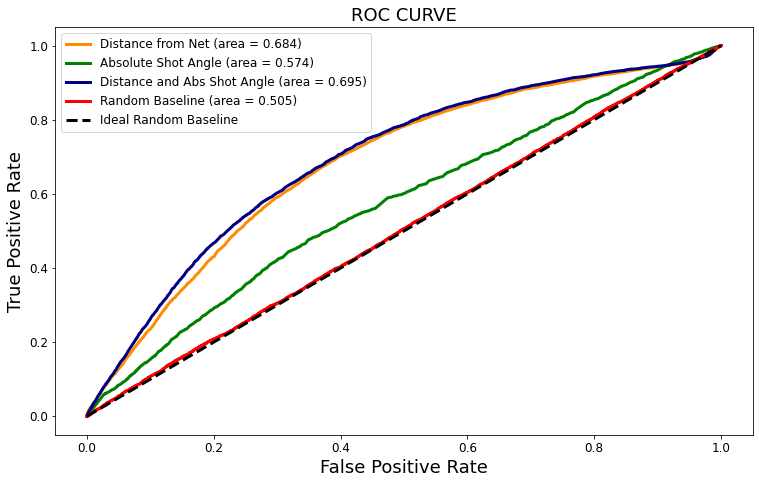

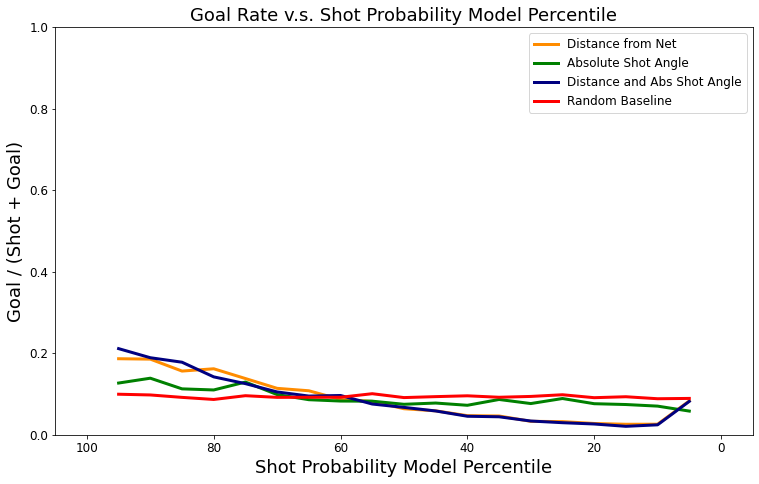

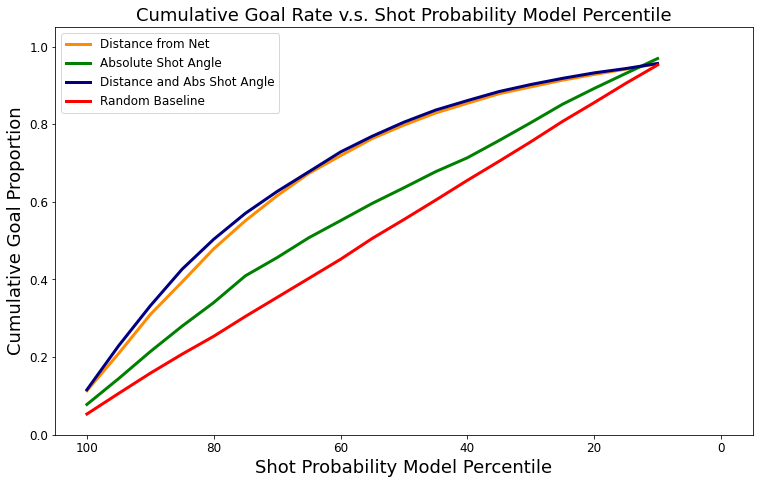

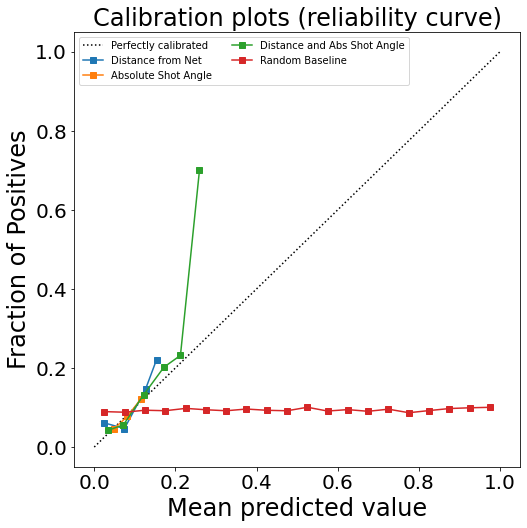

In [17]:
experiment.log_figure(figure=roc_auc_plot(list_model_iter,df_roc,df_auc,question_no), overwrite=False)
experiment.log_figure(figure=goal_rate_plot(list_model_iter,df_perc_prop,n_bins,question_no), overwrite=False)
experiment.log_figure(figure=cum_rate_plot(list_model_iter,df_perc_prop_cum,n_bins,question_no), overwrite=False)
experiment.log_figure(figure=calibration_plot(list_model_iter,df_calib,n_bins,length,question_no), overwrite=False)

In [18]:
Experiment.end

<function comet_ml.experiment.BaseExperiment.end(self)>